In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import datetime as dt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import statsmodels
import matplotlib


In [4]:
df = pd.read_csv("differenced_data_365only.csv", parse_dates=[0])
df.set_index("date", inplace=True)

In [5]:
normal_df_full = pd.read_csv("model_data.csv", parse_dates=[1])
normal_df_full.drop(["Unnamed: 0", "year sin", "year cos"], axis=1, inplace=True)
normal_df_full.set_index("Date", inplace=True)
normal_df = normal_df_full.loc[normal_df_full.index.date > dt.date(2019, 10, 1)]

In [6]:
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]

In [7]:
scaler = StandardScaler()
scaler.fit(train_df)

StandardScaler()

In [8]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [9]:
input_width = 6
label_width = 6
shift = 1
label_columns = None

In [10]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

In [11]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns is not None:
        labels = tf.stack(
            [labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [12]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [13]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)

In [14]:
model = tf.keras.models.load_model("saved_tuning_models/loss_42")

In [15]:
predictions = model.predict(model_test)

In [16]:
self_feed = []
double_predictions = model.predict(np.expand_dims(test_scaled[:6], axis=0))
self_feed.append(double_predictions)
for i in range(5):
    double_predictions = model.predict(double_predictions)
    self_feed.append(double_predictions)

feed_back_predictions = np.array(self_feed).reshape(-1, 12)

In [17]:
double_df = pd.DataFrame(feed_back_predictions, columns=df.columns, index=test_df[:len(feed_back_predictions)].index)

In [18]:
double_transformed = scaler.inverse_transform(double_df)
double_transformed = pd.DataFrame(double_transformed, columns=df.columns, index=double_df.index)
double_transformed += normal_df_full.loc[test_df[:len(feed_back_predictions)].index.map(lambda x: x - dt.timedelta(days=365))].values

In [19]:
output_df = pd.DataFrame(predictions[:,5,:], columns=df.columns, index=test_df[6:].index)
residuals_df = output_df - test_scaled[6:]


In [20]:
prev_index = test_df.index.map(lambda x: x-dt.timedelta(days=365))

In [21]:
transformed_df = scaler.inverse_transform(output_df)
transformed_df = pd.DataFrame(transformed_df, columns=output_df.columns, index=output_df.index)
transformed_df += normal_df_full.loc[prev_index][6:].values

In [22]:
transformed_residuals = transformed_df - normal_df_full.loc[test_df.index][6:].values
double_residuals = double_transformed - normal_df_full.loc[double_transformed.index].values

In [23]:
%matplotlib inline

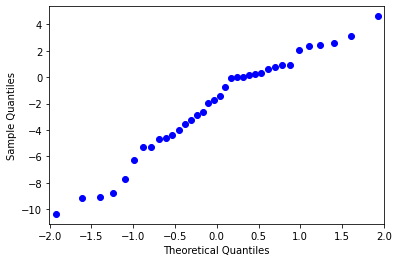

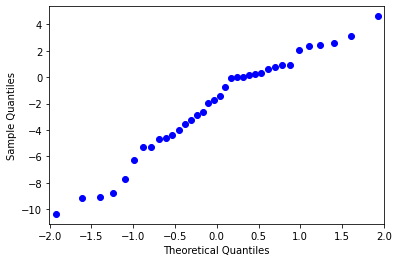

In [24]:
# sm.graphics.qqplot(residuals_df["temp"])
sm.graphics.qqplot(double_residuals["temp"])

In [25]:
# sm.graphics.qqplot(transformed_df["temp"])
df.columns

Index(['temp', 'dewp', 'slp', 'visib', 'wdsp', 'max', 'min', 'fog',
       'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder'],
      dtype='object')

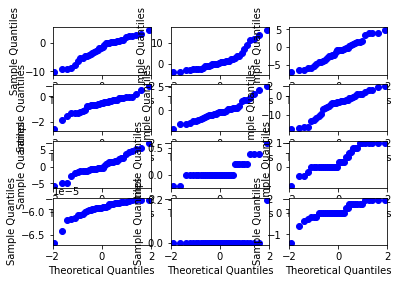

In [26]:

fig, axs = plt.subplots(4, 3)
sm.graphics.qqplot(double_residuals["temp"], ax=axs[0, 0])
sm.graphics.qqplot(double_residuals["dewp"], ax=axs[0, 1])
sm.graphics.qqplot(double_residuals["slp"], ax=axs[0, 2])
sm.graphics.qqplot(double_residuals["visib"], ax=axs[1, 0])
sm.graphics.qqplot(double_residuals["wdsp"], ax=axs[1, 1])
sm.graphics.qqplot(double_residuals["max"], ax=axs[1, 2])
sm.graphics.qqplot(double_residuals["min"], ax=axs[2, 0])
sm.graphics.qqplot(double_residuals["fog"], ax=axs[2, 1])
sm.graphics.qqplot(double_residuals["rain_drizzle"], ax=axs[2, 2])
sm.graphics.qqplot(double_residuals["snow_ice_pellets"], ax=axs[3, 0])
sm.graphics.qqplot(double_residuals["hail"], ax=axs[3, 1])
sm.graphics.qqplot(double_residuals["thunder"], ax=axs[3, 2])

plt.show()

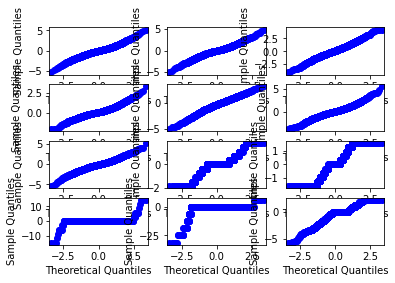

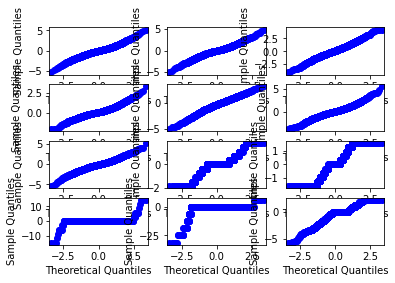

In [27]:
fig, axs = plt.subplots(4, 3)
ax1 = axs[0, 0]
sm.graphics.qqplot(residuals_df["temp"], ax=ax1)
sm.graphics.qqplot(residuals_df["dewp"], ax=axs[0, 1])
sm.graphics.qqplot(residuals_df["slp"], ax=axs[0, 2])
sm.graphics.qqplot(residuals_df["visib"], ax=axs[1, 0])
sm.graphics.qqplot(residuals_df["wdsp"], ax=axs[1, 1])
sm.graphics.qqplot(residuals_df["max"], ax=axs[1, 2])
sm.graphics.qqplot(residuals_df["min"], ax=axs[2, 0])
sm.graphics.qqplot(residuals_df["fog"], ax=axs[2, 1])
sm.graphics.qqplot(residuals_df["rain_drizzle"], ax=axs[2, 2])
sm.graphics.qqplot(residuals_df["snow_ice_pellets"], ax=axs[3, 0])
sm.graphics.qqplot(residuals_df["hail"], ax=axs[3, 1])
sm.graphics.qqplot(residuals_df["thunder"], ax=axs[3, 2])

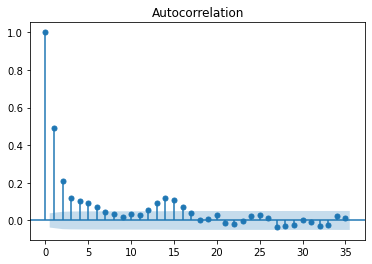

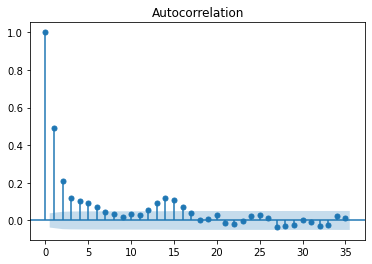

In [28]:
# sm.graphics.qqplot(transformed_residuals["temp"])
# plt.plot(transformed_residuals["temp"])
statsmodels.graphics.tsaplots.plot_acf(transformed_residuals["temp"])